<a href="https://colab.research.google.com/github/chad-fisher/KansasWind/blob/main/Kansas_Windfarms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!pip install matplotlib_scalebar
!pip install contextily
!pip install wget
!pip install rasterstats

In [ ]:
#Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as cx
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import wget
import zipfile
import datetime
import urllib
import rasterstats
import glob
from rasterio.merge import merge

stuff to do:
- wind turbine data
- kansas borders data
- clip data, so we just have turbine data for kansas

# Data Collection and Cleaning

## Wind Turbine Data

In [ ]:
#!wget "https://eerscmap.usgs.gov/uswtdb/assets/data/uswtdbSHP.zip"
#zipfile.ZipFile('uswtdbSHP.zip').extractall()

In [ ]:
path='/content/WTDB/uswtdb_v6_1_20231128.shp'
KS_WT = gpd.read_file(path)[gpd.read_file(path)['t_state'] == 'KS']

## State Data

In [ ]:
#!wget "https://www2.census.gov/geo/tiger/TIGER2023/STATE/tl_2023_us_state.zip"
#zipfile.ZipFile('tl_2023_us_state.zip').extractall()
#download, put in dataframe, and reproject / put on map

In [ ]:
StatesMap = gpd.read_file('/content/States/tl_2023_us_state.shp')

## Wind Turbine Map

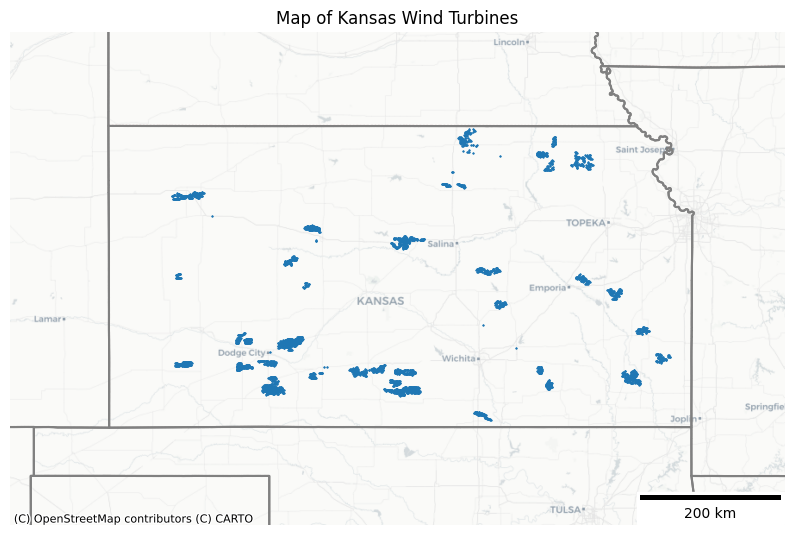

In [ ]:
ax = KS_WT.to_crs(epsg=3857).plot(figsize=(10,10),marker='*',markersize=0.5)
StatesMap.to_crs(epsg=3857).boundary.plot(ax=ax, color = 'gray')
# Adjust xlim and ylim to "zoom out" the map
plt.xlim(-1.15e7, -1.04e7)  # Adjust xmin and xmax values accordingly
plt.ylim(4.3e6, 5e6)

plt.title("Map of Kansas Wind Turbines")
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.add_artist(ScaleBar(1,location='lower right'))
plt.savefig("KansasWindTurbinesMap.png")

## Land Cover Data

In [ ]:
#!wget "https://s3-us-west-2.amazonaws.com/mrlc/nlcd_2021_land_cover_l48_20230630.zip"
#zipfile.ZipFile('nlcd_2021_land_cover_l48_20230630.zip').extractall()

In [ ]:
#open image file using raster rio
img = rio.open('/content/LandCover/nlcd_2021_land_cover_l48_20230630.img')

In [ ]:
KS_StateMap = StatesMap[StatesMap['NAME'] == 'Kansas']
KS_StateMap

,REGION,DIVISION,STATEFP,STATENS,GEOID,GEOIDFQ,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
47,2,4,20,00481813,20,0400000US20,KS,Kansas,00,G4000,A,211753777631,1345707708,+38.4985464,-098.3834298,"POLYGON ((-94.61764 37.76124, -94.61766 37.760..."


In [ ]:
img.crs

CRS.from_wkt('PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["meters",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [ ]:
KS_StateMap.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [ ]:
KS_StateMap.to_crs(img.crs).crs

<Projected CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84" ...>
Name: Albers_Conical_Equal_Area
Axis Info [cartesian]:
- [east]: Easting (meters)
- [north]: Northing (meters)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
KS_LandCover,trans=mask(img,KS_StateMap.to_crs(img.crs).geometry,crop=True)

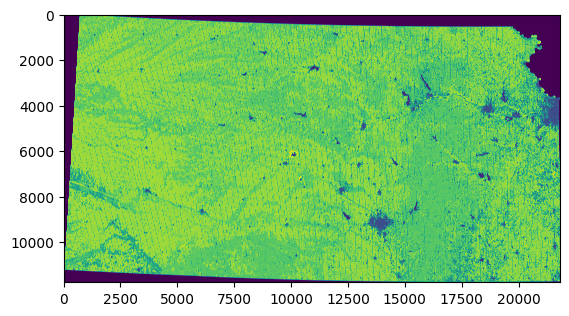

<Axes: >

In [ ]:
show(KS_LandCover)

In [ ]:
np.unique(KS_LandCover)

array([ 0, 11, 21, 22, 23, 24, 31, 41, 42, 43, 52, 71, 81, 82, 90, 95],
      dtype=uint8)

In [ ]:
nlcd_classes = [0, 11, 12, 21, 22, 23, 24, 31, 41, 42, 43, 52, 71, 81, 82, 90, 95]
nlcd_colors = ['#ffffff', '#476ba0', '#d1def8', '#decaca', '#d99482', '#ee0000', '#ab0000',
               '#b3aea3', '#68ab63', '#1c6330', '#b5ca8f', '#a68c30', '#ccba7d', '#e3e3c2',
               '#caca78', '#99c247', '#78ae94']

# Create colormap
nlcd_cmap = mpl.colors.ListedColormap(nlcd_colors)
bounds = np.array(nlcd_classes)
norm = mpl.colors.BoundaryNorm(bounds, nlcd_cmap.N)

#


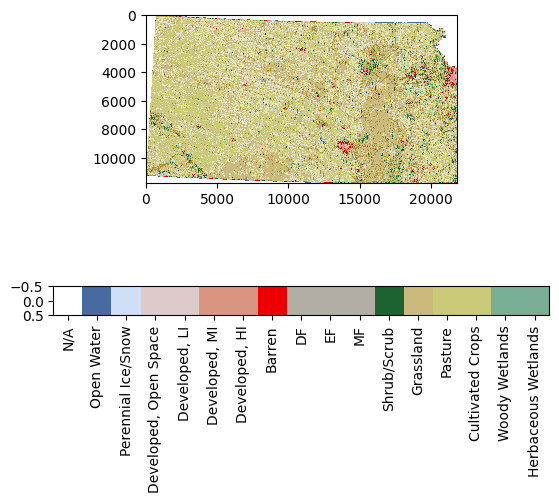

In [ ]:
fig, ax = plt.subplots(2,1)
show(KS_LandCover,ax=ax[0],cmap =nlcd_cmap)
ax[1].imshow([nlcd_classes],cmap=nlcd_cmap)
ax[1].set_xticks(ticks=np.arange(0,17),labels=['N/A','Open Water','Perennial Ice/Snow','Developed, Open Space','Developed, LI','Developed, MI','Developed, HI','Barren','DF','EF','MF','Shrub/Scrub','Grassland','Pasture','Cultivated Crops','Woody Wetlands','Herbaceous Wetlands'],rotation=90)
plt.savefig('Kansas Land Cover.png')

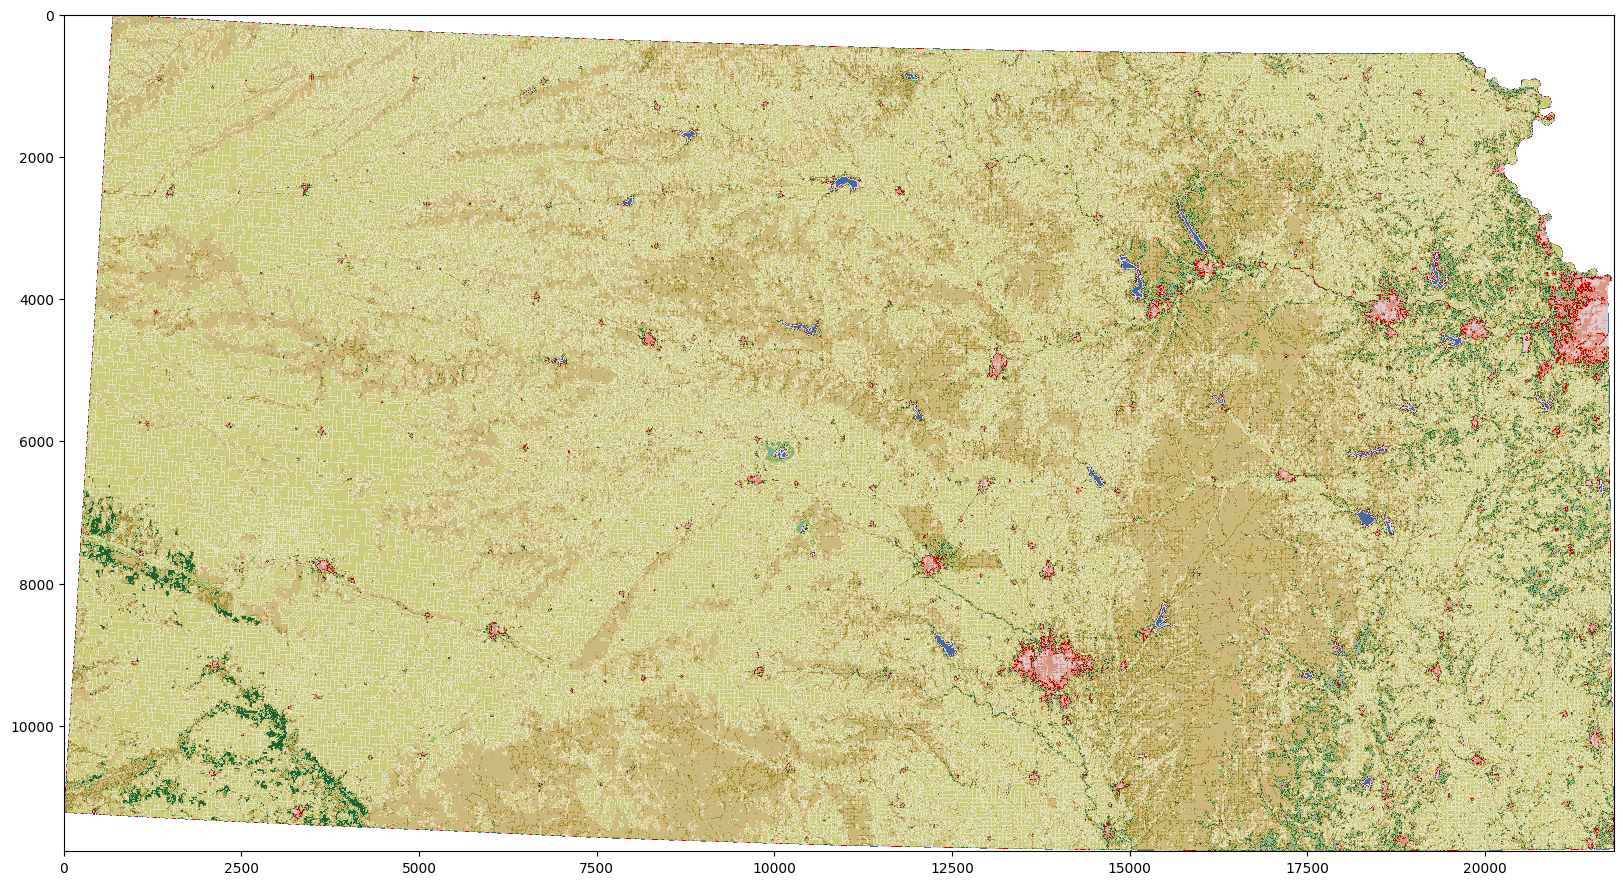

In [ ]:
f,ax=plt.subplots(figsize=(20,20))
ax=show(KS_LandCover,cmap =nlcd_cmap)

## Wind Speed Data

In [ ]:
m1_wind = rio.open('/content/MERRA/MERRA2_400.instM_2d_lfo_Nx.202301.nc4.nc4').read(1)
m2_wind = rio.open('/content/MERRA/MERRA2_400.instM_2d_lfo_Nx.202302.nc4.nc4').read(1)
m3_wind = rio.open('/content/MERRA/MERRA2_400.instM_2d_lfo_Nx.202303.nc4.nc4').read(1)
m4_wind = rio.open('/content/MERRA/MERRA2_400.instM_2d_lfo_Nx.202304.nc4.nc4').read(1)
m5_wind = rio.open('/content/MERRA/MERRA2_400.instM_2d_lfo_Nx.202305.nc4.nc4').read(1)
m6_wind = rio.open('/content/MERRA/MERRA2_400.instM_2d_lfo_Nx.202306.nc4.nc4').read(1)
m7_wind = rio.open('/content/MERRA/MERRA2_400.instM_2d_lfo_Nx.202307.nc4.nc4').read(1)
m8_wind = rio.open('/content/MERRA/MERRA2_400.instM_2d_lfo_Nx.202308.nc4.nc4').read(1)
m9_wind = rio.open('/content/MERRA/MERRA2_400.instM_2d_lfo_Nx.202309.nc4.nc4').read(1)
m10_wind = rio.open('/content/MERRA/MERRA2_400.instM_2d_lfo_Nx.202310.nc4.nc4').read(1)
m11_wind = rio.open('/content/MERRA/MERRA2_400.instM_2d_lfo_Nx.202311.nc4.nc4').read(1)
m12_wind = rio.open('/content/MERRA/MERRA2_400.instM_2d_lfo_Nx.202312.nc4.nc4').read(1)

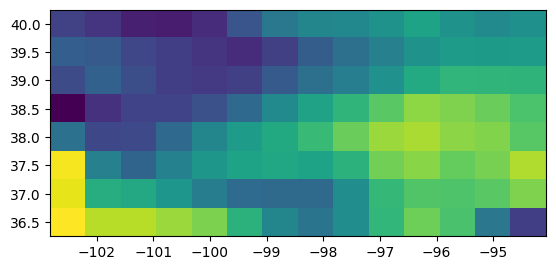

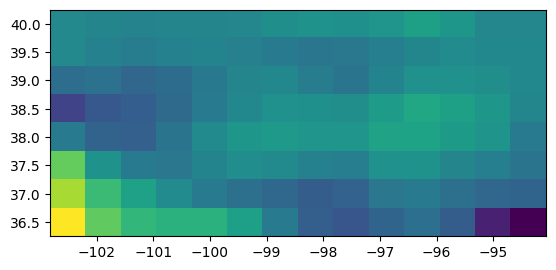

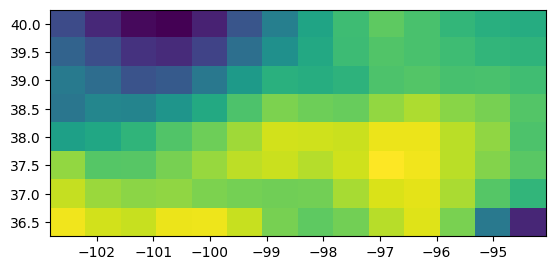

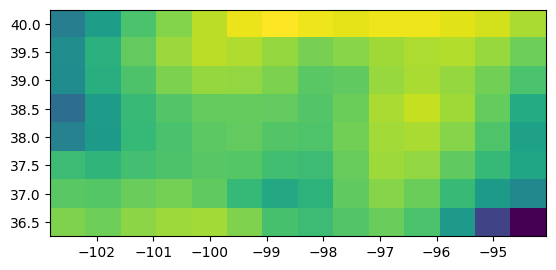

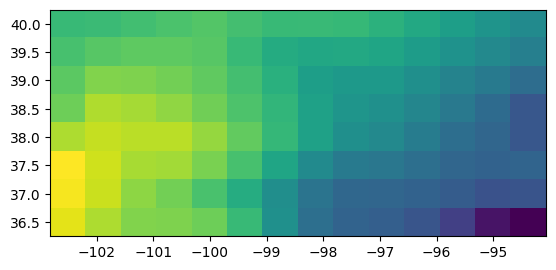

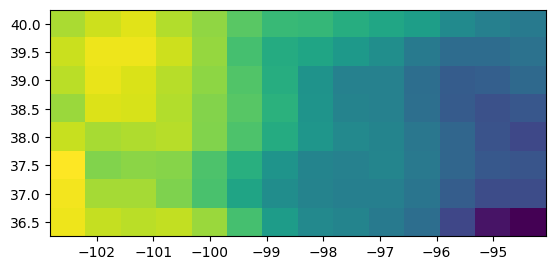

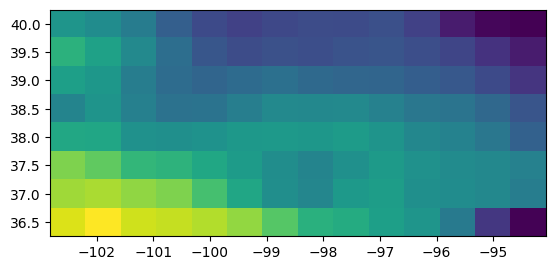

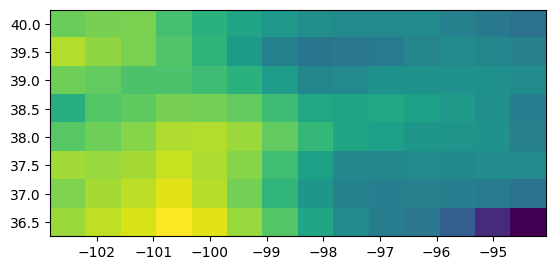

In [ ]:
for i in np.arange(1,9):
  show(rio.open('/content/MERRA/MERRA2_400.instM_2d_lfo_Nx.20230'+str(i)+'.nc4.nc4'))

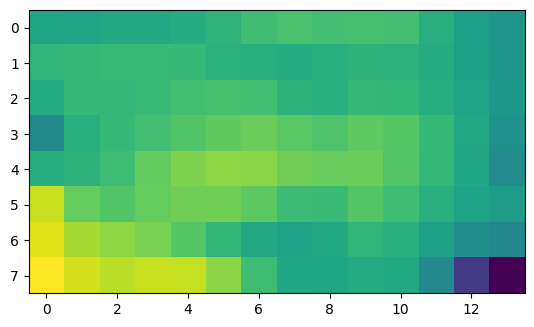

<Axes: >

In [ ]:
avg_wind=(m1_wind+m2_wind+m3_wind+m4_wind+m5_wind+m6_wind+m7_wind+m8_wind+m9_wind+m10_wind+m11_wind+m12_wind)/12
show(avg_wind)

## DEM Data

In [ ]:
DEM_list=glob.glob('/content/DEMS/*.tif')
src_files_to_mosaic = []
for fp in DEM_list:
  src = rio.open(fp)
  src_files_to_mosaic.append(src)
mosaic, out_trans = merge(src_files_to_mosaic)

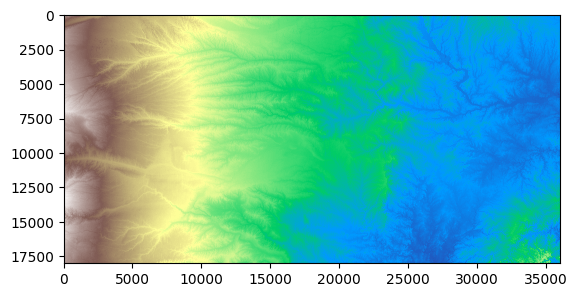

<Axes: >

In [ ]:
show(mosaic,cmap='terrain')

## Power Lines Data

In [ ]:
powerLines = gpd.read_file('/content/PowerLines/Electric_Power_Transmission_Lines_A.shp')

In [ ]:
ax = powerLines.to_crs(epsg=3857).clip(KS_StateMap.to_crs(epsg=3857)).plot(figsize=(10,10))
KS_WT.to_crs(epsg=3857).plot(ax=ax,color = 'red')
StatesMap.to_crs(epsg=3857).boundary.plot(ax=ax, color = 'gray')
# Adjust xlim and ylim to "zoom out" the map
plt.xlim(-1.15e7, -1.04e7)  # Adjust xmin and xmax values accordingly
plt.ylim(4.3e6, 5e6)

plt.title("Map of Kansas Wind Turbines")
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.add_artist(ScaleBar(1,location='lower right'))
plt.savefig("KansasWindTurbinesMap.png")

KeyboardInterrupt: 

## Population Density Data

In [ ]:
#https://data.census.gov/table/ACSDT5Y2022.B01001?t=Populations%20and%20People&g=040XX00US20$1500000&y=2022
Pop_Data=pd.read_csv('/content/Pop Data/PopData.csv')
KS_BG=gpd.read_file('/content/Pop Data/tl_2023_20_bg.shp')

In [ ]:
Pop_Data['Fix_ID']=Pop_Data['GEO_ID'].str[-7:]

In [ ]:
Pop_Data

,GEO_ID,NAME,Total_Pop,Fix_ID
0,1500000US200019526001,Block Group 1; Census Tract 9526; Allen County...,1946,9526001
1,1500000US200019527001,Block Group 1; Census Tract 9527; Allen County...,986,9527001
2,1500000US200019527002,Block Group 2; Census Tract 9527; Allen County...,921,9527002
3,1500000US200019528001,Block Group 1; Census Tract 9528; Allen County...,928,9528001
4,1500000US200019528002,Block Group 2; Census Tract 9528; Allen County...,1711,9528002
...,...,...,...,...
2456,1500000US202099800001,Block Group 1; Census Tract 9800; Wyandotte Co...,0,9800001
2457,1500000US202099805001,Block Group 1; Census Tract 9805; Wyandotte Co...,0,9805001
2458,1500000US202099809001,Block Group 1; Census Tract 9809; Wyandotte Co...,0,9809001
2459,1500000US202099812001,Block Group 1; Census Tract 9812; Wyandotte Co...,0,9812001


In [ ]:
KS_BG['ID']=KS_BG['GEOIDFQ'].str[-7:]

In [ ]:
KS_BG

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,GEOIDFQ,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,ID
0,20,155,001000,1,201550010001,1500000US201550010001,Block Group 1,G5030,S,1563483,0,+38.0623344,-097.8990927,"POLYGON ((-97.90705 38.05078, -97.90704 38.051...",0010001
1,20,155,000600,3,201550006003,1500000US201550006003,Block Group 3,G5030,S,512982,0,+38.0580460,-097.9268721,"POLYGON ((-97.93186 38.05962, -97.93186 38.059...",0006003
2,20,155,001300,1,201550013001,1500000US201550013001,Block Group 1,G5030,S,9838091,354197,+38.0123868,-097.9230430,"POLYGON ((-97.94053 38.00166, -97.94050 38.002...",0013001
3,20,173,006000,2,201730060002,1500000US201730060002,Block Group 2,G5030,S,2162950,509532,+37.6300070,-097.3277545,"POLYGON ((-97.33552 37.64480, -97.33145 37.641...",0060002
4,20,173,006000,5,201730060005,1500000US201730060005,Block Group 5,G5030,S,663712,0,+37.6404878,-097.3222264,"POLYGON ((-97.32639 37.64591, -97.32498 37.645...",0060005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2456,20,161,001301,3,201610013013,1500000US201610013013,Block Group 3,G5030,S,14331357,0,+39.2126965,-096.6526796,"POLYGON ((-96.67927 39.21088, -96.67904 39.211...",0013013
2457,20,065,952300,3,200659523003,1500000US200659523003,Block Group 3,G5030,S,2277446944,599356,+39.2416812,-100.0239220,"POLYGON ((-100.16435 39.13498, -100.16424 39.1...",9523003
2458,20,065,952300,2,200659523002,1500000US200659523002,Block Group 2,G5030,S,26639982,0,+39.3604317,-099.8231393,"POLYGON ((-99.84668 39.32942, -99.84663 39.332...",9523002
2459,20,065,952300,1,200659523001,1500000US200659523001,Block Group 1,G5030,S,23086927,0,+39.3714344,-099.8737418,"POLYGON ((-99.90330 39.35998, -99.90326 39.360...",9523001


In [ ]:
KS_Pop = KS_BG.merge(Pop_Data, left_on='ID',right_on='Fix_ID')

In [ ]:
KS_Pop

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,GEOIDFQ,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,ID,GEO_ID,NAME,Total_Pop,Fix_ID
0,20,155,001000,1,201550010001,1500000US201550010001,Block Group 1,G5030,S,1563483,0,+38.0623344,-097.8990927,"POLYGON ((-97.90705 38.05078, -97.90704 38.051...",0010001,1500000US201550010001,Block Group 1; Census Tract 10; Reno County; K...,948,0010001
1,20,155,001000,1,201550010001,1500000US201550010001,Block Group 1,G5030,S,1563483,0,+38.0623344,-097.8990927,"POLYGON ((-97.90705 38.05078, -97.90704 38.051...",0010001,1500000US201690010001,Block Group 1; Census Tract 10; Saline County;...,2968,0010001
2,20,155,001000,1,201550010001,1500000US201550010001,Block Group 1,G5030,S,1563483,0,+38.0623344,-097.8990927,"POLYGON ((-97.90705 38.05078, -97.90704 38.051...",0010001,1500000US201730010001,Block Group 1; Census Tract 10; Sedgwick Count...,1340,0010001
3,20,155,001000,1,201550010001,1500000US201550010001,Block Group 1,G5030,S,1563483,0,+38.0623344,-097.8990927,"POLYGON ((-97.90705 38.05078, -97.90704 38.051...",0010001,1500000US201770010001,Block Group 1; Census Tract 10; Shawnee County...,487,0010001
4,20,173,001000,1,201730010001,1500000US201730010001,Block Group 1,G5030,S,989459,1761,+37.7027952,-097.2887198,"POLYGON ((-97.29353 37.69831, -97.29352 37.699...",0010001,1500000US201550010001,Block Group 1; Census Tract 10; Reno County; K...,948,0010001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3592,20,161,001301,3,201610013013,1500000US201610013013,Block Group 3,G5030,S,14331357,0,+39.2126965,-096.6526796,"POLYGON ((-96.67927 39.21088, -96.67904 39.211...",0013013,1500000US201610013013,Block Group 3; Census Tract 13.01; Riley Count...,1258,0013013
3593,20,065,952300,3,200659523003,1500000US200659523003,Block Group 3,G5030,S,2277446944,599356,+39.2416812,-100.0239220,"POLYGON ((-100.16435 39.13498, -100.16424 39.1...",9523003,1500000US200659523003,Block Group 3; Census Tract 9523; Graham Count...,742,9523003
3594,20,065,952300,2,200659523002,1500000US200659523002,Block Group 2,G5030,S,26639982,0,+39.3604317,-099.8231393,"POLYGON ((-99.84668 39.32942, -99.84663 39.332...",9523002,1500000US200659523002,Block Group 2; Census Tract 9523; Graham Count...,989,9523002
3595,20,065,952300,1,200659523001,1500000US200659523001,Block Group 1,G5030,S,23086927,0,+39.3714344,-099.8737418,"POLYGON ((-99.90330 39.35998, -99.90326 39.360...",9523001,1500000US200659523001,Block Group 1; Census Tract 9523; Graham Count...,699,9523001


<Axes: >

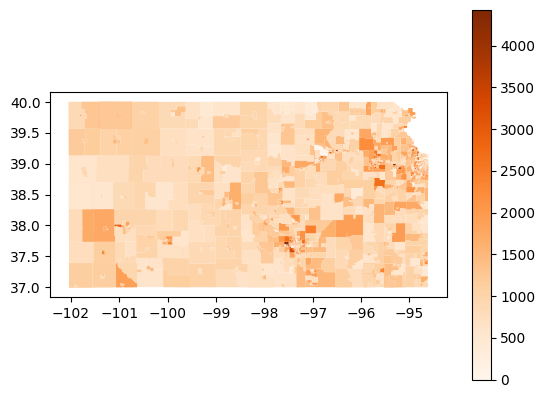

In [ ]:
KS_Pop.plot(column='Total_Pop',legend=True,cmap='Oranges')

## Soils Data

In [ ]:
soils = gpd.read_file('/content/Soils/Soils.shp')

## Annual Precipitation

In [ ]:
annual_precip = pd.read_csv('/content/AnnualPrecipitation/PrecipTotal-2023.csv')
UScounties = gpd.read_file('/content/AnnualPrecipitation/tl_2023_us_county.shp')

In [ ]:
annual_precip

,County,Year,Total
0,Allen,2023,28.92
1,Anderson,2023,29.48
2,Atchison,2023,30.45
3,Barber,2023,32.87
4,Barton,2023,24.75
...,...,...,...
100,Washington,2023,23.78
101,Wichita,2023,22.63
102,Wilson,2023,30.59
103,Woodson,2023,27.34


In [ ]:
UScounties

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,0500000US31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477563029,10772508,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,0500000US53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680980771,61564427,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.26449, -123.72755 46.2..."
2,35,011,00933054,35011,0500000US35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.89337 34.08894, -104.89337 34.0..."
3,31,109,00835876,31109,0500000US31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169269688,22850324,+40.7835474,-096.6886584,"POLYGON ((-96.68493 40.52330, -96.69219 40.523..."
4,31,129,00835886,31129,0500000US31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645187,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27370 40.11840, -98.27374 40.122..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3230,13,123,00351260,13123,0500000US13123,Gilmer,Gilmer County,06,H1,G4020,None,None,None,A,1103893380,12276629,+34.6905232,-084.4548113,"POLYGON ((-84.30237 34.57832, -84.30329 34.577..."
3231,27,135,00659513,27135,0500000US27135,Roseau,Roseau County,06,H1,G4020,None,None,None,A,4329782924,16924046,+48.7610683,-095.8215042,"POLYGON ((-95.25857 48.88666, -95.25707 48.885..."
3232,28,089,00695768,28089,0500000US28089,Madison,Madison County,06,H1,G4020,298,27140,None,A,1849790735,72085470,+32.6343703,-090.0341603,"POLYGON ((-90.14883 32.40026, -90.14890 32.400..."
3233,48,227,01383899,48227,0500000US48227,Howard,Howard County,06,H1,G4020,None,13700,None,A,2333039148,8841781,+32.3034298,-101.4387208,"POLYGON ((-101.18138 32.21252, -101.18138 32.2..."


In [ ]:
KS_counties = UScounties[UScounties['STATEFP'] == '20']

In [ ]:
KS_counties

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
60,20,073,00485003,20073,0500000US20073,Greenwood,Greenwood County,06,H1,G4020,None,None,None,A,2961143637,24145021,+37.8793472,-096.2417321,"POLYGON ((-96.35809 38.08638, -96.35808 38.088..."
69,20,043,00484991,20043,0500000US20043,Doniphan,Doniphan County,06,H1,G4020,312,41140,None,A,1019096302,12433564,+39.7885021,-095.1472253,"POLYGON ((-95.02152 39.67065, -95.02243 39.670..."
77,20,157,00485042,20157,0500000US20157,Republic,Republic County,06,H1,G4020,None,None,None,A,1857998455,7951912,+39.8289061,-097.6508830,"POLYGON ((-97.36923 39.91492, -97.36923 39.912..."
111,20,039,00484989,20039,0500000US20039,Decatur,Decatur County,06,H1,G4020,None,None,None,A,2314199321,1631670,+39.7835420,-100.4597084,"POLYGON ((-100.74008 39.91620, -100.73992 39.9..."
151,20,147,00485037,20147,0500000US20147,Phillips,Phillips County,06,H1,G4020,None,None,None,A,2294395646,22493383,+39.7845058,-099.3421498,"POLYGON ((-99.29091 40.00195, -99.29080 40.002..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3084,20,155,00485041,20155,0500000US20155,Reno,Reno County,06,H1,G4020,None,26740,None,A,3251231985,43517492,+37.9481849,-098.0783463,"POLYGON ((-97.80782 37.73385, -97.80811 37.733..."
3123,20,069,00485001,20069,0500000US20069,Gray,Gray County,06,H1,G4020,None,None,None,A,2250356175,1113338,+37.7445134,-100.4517163,"POLYGON ((-100.22732 37.85590, -100.22749 37.8..."
3160,20,197,00485059,20197,0500000US20197,Wabaunsee,Wabaunsee County,06,H1,G4020,None,45820,None,A,2057320865,13845234,+38.9551537,-096.2012619,"POLYGON ((-96.18664 38.73898, -96.19208 38.738..."
3202,20,173,00485049,20173,0500000US20173,Sedgwick,Sedgwick County,06,H1,G4020,556,48620,None,A,2582220576,31390123,+37.6810450,-097.4610535,"POLYGON ((-97.36901 37.47727, -97.36919 37.477..."


In [ ]:
KS_counties_precip = KS_counties.merge(annual_precip, left_on='NAME',right_on='County')

In [ ]:
KS_counties_precip

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,...,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,County,Year,Total
0,20,073,00485003,20073,0500000US20073,Greenwood,Greenwood County,06,H1,G4020,...,None,A,2961143637,24145021,+37.8793472,-096.2417321,"POLYGON ((-96.35809 38.08638, -96.35808 38.088...",Greenwood,2023,27.45
1,20,043,00484991,20043,0500000US20043,Doniphan,Doniphan County,06,H1,G4020,...,None,A,1019096302,12433564,+39.7885021,-095.1472253,"POLYGON ((-95.02152 39.67065, -95.02243 39.670...",Doniphan,2023,31.71
2,20,157,00485042,20157,0500000US20157,Republic,Republic County,06,H1,G4020,...,None,A,1857998455,7951912,+39.8289061,-097.6508830,"POLYGON ((-97.36923 39.91492, -97.36923 39.912...",Republic,2023,22.06
3,20,039,00484989,20039,0500000US20039,Decatur,Decatur County,06,H1,G4020,...,None,A,2314199321,1631670,+39.7835420,-100.4597084,"POLYGON ((-100.74008 39.91620, -100.73992 39.9...",Decatur,2023,21.09
4,20,147,00485037,20147,0500000US20147,Phillips,Phillips County,06,H1,G4020,...,None,A,2294395646,22493383,+39.7845058,-099.3421498,"POLYGON ((-99.29091 40.00195, -99.29080 40.002...",Phillips,2023,19.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,20,155,00485041,20155,0500000US20155,Reno,Reno County,06,H1,G4020,...,None,A,3251231985,43517492,+37.9481849,-098.0783463,"POLYGON ((-97.80782 37.73385, -97.80811 37.733...",Reno,2023,26.29
101,20,069,00485001,20069,0500000US20069,Gray,Gray County,06,H1,G4020,...,None,A,2250356175,1113338,+37.7445134,-100.4517163,"POLYGON ((-100.22732 37.85590, -100.22749 37.8...",Gray,2023,25.34
102,20,197,00485059,20197,0500000US20197,Wabaunsee,Wabaunsee County,06,H1,G4020,...,None,A,2057320865,13845234,+38.9551537,-096.2012619,"POLYGON ((-96.18664 38.73898, -96.19208 38.738...",Wabaunsee,2023,27.73
103,20,173,00485049,20173,0500000US20173,Sedgwick,Sedgwick County,06,H1,G4020,...,None,A,2582220576,31390123,+37.6810450,-097.4610535,"POLYGON ((-97.36901 37.47727, -97.36919 37.477...",Sedgwick,2023,28.86


<Axes: >

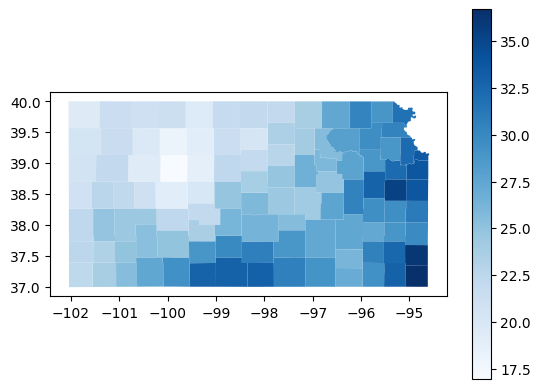

In [ ]:
KS_counties_precip.plot(column='Total',legend=True,cmap='Blues')

## Air Density

# Spatial random forest?

In [ ]:
!git clone https://github.com/mie-lab/spatial_rf_python.git


fatal: destination path 'spatial_rf_python' already exists and is not an empty directory.


In [ ]:
import sprf

ModuleNotFoundError: No module named 'sprf'